### Compute the score for each edge based on the embedding of the two nodes
Only consider connected graph\
The score is computed using the distance of the two vectors, and would be large if the embeddings are different.

In [1]:
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_sparse import coalesce

from torch.nn import PairwiseDistance
import torch_geometric.transforms as T
import torch_geometric.utils as U
from torch_geometric.data import Data

import networkx as nx
from cluster import *

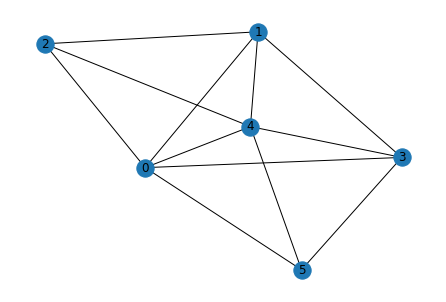

In [2]:
G = nx.connected_watts_strogatz_graph(n=6, k=4, p=0.4)
nx.draw(G, with_labels=True)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
G0.x = torch.randn(6,3) # feature_size = 3
x = G0.x

In [3]:
edge_score = compute_distance_score(p_norm=2, normalize = True, edge_index = edge_index, x=x)
print(edge_score)
print(edge_index)

tensor([0.9190, 1.5000, 0.9168, 0.8491, 0.9487, 0.9487, 0.5000, 1.3700, 0.9269,
        1.5000, 1.3700, 1.3615, 0.8491, 0.9269, 0.8915, 0.8433, 0.9168, 0.5000,
        1.3615, 0.8915, 0.7325, 0.9190, 0.8433, 0.7325])
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5],
        [5, 2, 4, 3, 1, 0, 4, 2, 3, 0, 1, 4, 0, 1, 4, 5, 0, 1, 2, 3, 5, 0, 3, 4]])


In [24]:
def compute_distance_score(self, edge_index=[], x=[]):
            pdist = PairwiseDistance(self.p)
            dist = pdist(x[edge_index[0]], x[edge_index[1]])
            
            if self.normalize == True:
                dist_norm = (dist - torch.min(dist)) / (torch.max(dist) - torch.min(dist))
                dist_norm = dist_norm + self.self_add
            else:
                dist_norm = dist
            return dist_norm

In [25]:
def node__cluster_search(self, edge_score, edge_index, i):
        selected_score = []
        in_cluster = [i]
        selected_edge = torch.tensor([])
        while (sum(selected_score) < self.upper_bound):
            potential_edge_index = torch.tensor([])
            potential_score = torch.tensor([])
            for i in in_cluster:
                # the first element in edge is in cluster
                potential_edge_index = torch.cat([potential_edge_index, edge_index[:,edge_index[0]==i]], dim=-1) 
                potential_score = torch.cat([potential_score, edge_score[edge_index[0]==i]], dim=-1)
                for j in in_cluster:
                    potential_score = potential_score[potential_edge_index[1]!=j]
                    potential_edge_index = potential_edge_index[:,potential_edge_index[1]!=j]
            if (potential_score.shape[0]==0):
                print('The current cluster has contained all nodes in the graph')
                break
            added_score = torch.min(potential_score)
            added_edge = potential_edge_index[:,torch.where(potential_score==added_score)[0].numpy()]
            selected_edge = torch.cat([selected_edge, added_edge], dim=-1)   
            selected_score += [added_score.item()]
            in_cluster += [int(added_edge[1].item())]
        if (self.greedy==False):
            in_cluster = in_cluster[0:(len(in_cluster)-1)]
            selected_edge = selected_edge[:,0:(selected_edge.shape[1]-1)]
            selected_score = selected_score[0:(len(selected_score)-1)]

        return in_cluster, selected_edge, selected_score

In [5]:
adj = U.to_dense_adj(edge_index)[0]
adj_new = torch.matmul(torch.matmul(selected_assignment_matrix,adj),selected_assignment_matrix.t()) # connectivity relationship
adj_new[adj_new>0] = 1
edge_index_new = U.remove_self_loops(U.dense_to_sparse(adj_new)[0])[0]
edge_index_new

tensor([[0, 1],
        [1, 0]])

In [6]:
x_new = torch.matmul(selected_node_score_matrix, x)
x_new

tensor([[ 0.2024,  2.2025, -0.0209],
        [ 1.0980,  0.3103,  0.0671]])

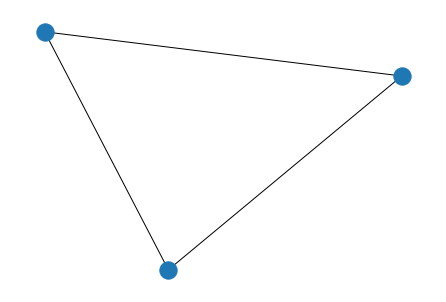

In [8]:
data = Data(x=x_new, edge_index=edge_index_new)
G_new = U.to_networkx(data, to_undirected=True)
nx.draw(G_new)